## Diffusion Distances
### Random Walk Behavoir

We investigate the expected length of random walks from the boundary of a district to another district.

In [41]:
import matplotlib.pyplot as plt
from gerrychain.random import random
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from gerrychain.tree import recursive_tree_part
from gerrychain.metrics import mean_median, efficiency_gap, polsby_popper, partisan_gini
from functools import (partial, reduce)
import pandas
import geopandas as gp
from maup import assign
import maup
import numpy as np
import networkx as nx
import pickle
import seaborn as sns
import pprint
import operator
import scipy
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from gerrychain.updaters import cut_edges

### Functions

In [42]:
## This function takes a name of a shapefile and returns a tuple of the graph
## and its associated dataframe
def build_graph(filename):
    print("Pulling in Graph from Shapefile: " + filename)
    graph = Graph.from_file(filename)
    df = gp.read_file(filename)
    return(graph, df)

In [43]:
def config_markov_chain(initial_part, iters=1000, epsilon=0.05):
    # The recom proposal needs to know the ideal population for the districts so
    # that we can improve speed by bailing early on unbalanced partitions.
    ideal_population = sum(initial_part["population"].values()) / len(initial_part)


    # We use functools.partial to bind the extra parameters (pop_col, pop_target,
    # epsilon, node_repeats) of the recom proposal.
    proposal = partial(recom,
                       pop_col="TOTPOP",
                       pop_target=ideal_population,
                       epsilon=epsilon,
                       node_repeats=1)

    # To keep districts about as compact as the original plan, we bound the number
    # of cut edges at 2 times the number of cut edges in the initial plan.
#     compactness_bound = constraints.UpperBound(lambda p: len(p["cut_edges"]),
#                         2*len(initial_part["cut_edges"]))

    cs = [constraints.within_percent_of_ideal_population(initial_part, epsilon)]


    # Configure the MarkovChain.
    return MarkovChain(proposal=proposal, constraints=cs, accept=accept.always_accept,
                       initial_state=initial_part, total_steps=iters)

### Set up initial partions to random walk over

In [44]:
graph, df = build_graph("./vrdi-graphs/IA-shapefiles/IA_counties/IA_counties.shp")

Pulling in Graph from Shapefile: ./vrdi-graphs/IA-shapefiles/IA_counties/IA_counties.shp


In [45]:
total_population = sum(df.TOTPOP.values)
ideal_population = total_population / 4
election = Election("PRES16", {"Dem": "PRES16D", "Rep": "PRES16R"})

In [46]:
my_updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges, "black_pop": updaters.Tally("BPOP", alias = "black_pop"),
    "nh_white": updaters.Tally("NH_WHITE", alias = "nh_white"),
    "nh_black": updaters.Tally("NH_BLACK", alias = "nh_black"),
    "hisp": updaters.Tally("HISP", alias = "hisp"),
    "vap": updaters.Tally("VAP", alias = "vap"),
    "hvap": updaters.Tally("HVAP", alias = "hvap"),
    "wvap": updaters.Tally("WVAP", alias = "wvap"),
    "bvap":updaters.Tally("BVAP", alias = "bvap")
}

In [47]:
initial_partition = GeographicPartition(graph, assignment="CD",
                                        updaters=my_updaters)

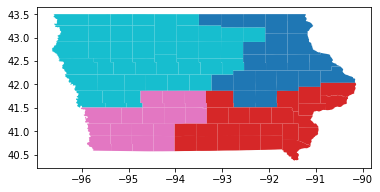

In [48]:
initial_partition.plot(df)

In [49]:
chain = config_markov_chain(initial_partition, iters=100, epsilon=0.01)

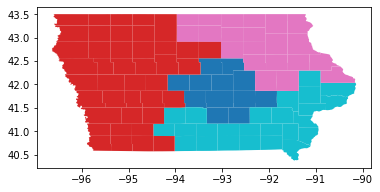

In [50]:
for part in chain:
    pass
part.plot(df)

In [13]:
n = len(list(graph.nodes()))

centroids = df.centroid
c_x = centroids.x
c_y = centroids.y
pos = {node:(c_x[node],c_y[node]) for node in graph.nodes}  

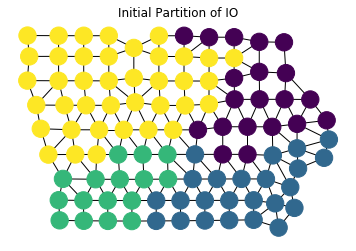

In [50]:
plt.figure()
plt.title("Initial Partition of IO")
nx.draw(graph,pos=pos, node_color=[initial_partition.assignment[x] for x in graph.nodes()])
plt.show()

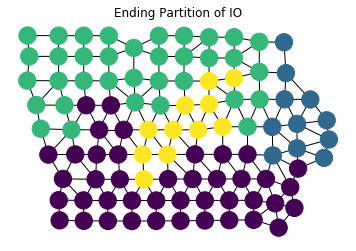

In [171]:
plt.figure()
plt.title("Ending Partition of IO")
nx.draw(graph,pos=pos, node_color=[part.assignment[x] for x in graph.nodes()])
plt.show()

In [ ]:
## Create two random partitions of Iowa into 4 districts
## Different labelling conventions for each partition to test our Hamming function (below)

num_dist = 4
ideal_population = sum(initial_partition["population"].values()) / len(
    initial_partition)
random_plan = recursive_tree_part(graph, ['1','2','3','4'], ideal_population, "TOTPOP", 0.001, 1)
base_partition = Partition(graph, random_plan, my_updaters)
random_plan_2 = recursive_tree_part(graph, range(len(initial_partition)), ideal_population, "TOTPOP", 0.001, 1)
new_partition = Partition(graph, random_plan_2, my_updaters)

### Random Walks

In [ ]:
## Choose source and target district
## Create set of target boundary nodes
## For each boundary node in the source randomly walk until reaching
## a boundary node in the target, and keep track of steps.

In [176]:
# Given a base_partition with some labelling and a new_partition, we would like
# the labelling of new_partition to be as close as possible to the base_partition.
# That is, we would like as many nodes as possible to remain in the same district.
# This function implements a greedy algorithm to do so (thus is not necessarily optimal).
# Outputs a dictionary that takes the labelling given by new_partition and
# says which label it should get. Also outputs the number of displaced nodes, i.e. the Hamming distance.
def greedy_hamming(base_partition, new_partition):
    names = [j for j in base_partition.parts]
    new_names = {}
    for i in new_partition.parts:
        intersection_sizes = {}
        for name in names:
            intersection_sizes.update({len(set(base_partition.assignment.parts[name]).intersection(set(new_partition.assignment.parts[i]))): name})
        new_names.update({intersection_sizes[max(intersection_sizes.keys())]: i})
        names.remove(intersection_sizes[max(intersection_sizes.keys())])
    tot_nodes = len(new_partition.assignment)
    final_int_sizes = []
    for i in base_partition.parts:
        x = len(set(new_partition.assignment.parts[new_names[i]]).intersection(set(base_partition.assignment.parts[i])))
        final_int_sizes.append(x)
    ham_dist = tot_nodes - sum(final_int_sizes)
    return new_names, ham_dist;

In [197]:
## This function take a name for the walker attribute, the name of the 
## target attribute, the name of the times attribute, the source 
## indentifier, and the target identifier.  It returns a dictionary of
## random walk state.
def init_rand_walk_state(walker_names, target_names, times_names, base_partition, new_partition, target):
    new_names = greedy_hamming(base_partition, new_partition)[0]
    rand_walk = dict()
    rand_walk[walker_names] = np.array(list(filter(lambda x: base_partition.assignment[x] == target,
                                                  graph.nodes())))
    rand_walk[target_names] = set(filter(lambda x: new_partition.assignment[x] == new_names[target],
                                         graph.nodes()))
    rand_walk[times_names] = np.zeros(len(rand_walk[walker_names]))
    return rand_walk

In [198]:
## This function takes a dictionary containing random walk state, and the 
## indentifers for the attributes, updates them if nescessary and returns
## True if the walk is ongoing and False if it is done.
def update_walkers(state, walker_names, target_names, times_names):
    not_done = []
    for i in range(len(state[walker_names])):
        if state[walker_names][i] in state[target_names]:
            not_done.append(False)
        else:
            state[times_names][i] += 1
            state[walker_names][i] = random.choice(list(graph.neighbors(state[walker_names][i])))
            not_done.append(True)
#     print(not_done)
    return any(not_done)

In [201]:
## Run one iteration of random walk, comparing district '1' 
## in the base_partition to the Hamming-assigned district '1' in the new partition
rand_walk_state = init_rand_walk_state("walkers", "target", "times", base_partition, new_partition, '1')
while update_walkers(rand_walk_state, "walkers", "target", "times"):
    pass

In [202]:
## Run 1000 random walks and collect data,
## again comparing the districts labelled '1'
time_data = []
for i in range(1000):
    rand_walk_state = init_rand_walk_state("walkers", "target", "times", base_partition, new_partition
                                      ,'1')
    while update_walkers(rand_walk_state, "walkers", "target", "times"):
        pass
    time_data.append(rand_walk_state["times"])

In [205]:
## Iterate over all districts in the base partition, and for each one do 1000 random walks
## and collect data

time_data = []
k = 0
for part in base_partition.parts:
    time_data.append([])
    for j in range(1000):
        rand_walk_state = init_rand_walk_state("walkers", "target", "times", base_partition, new_partition
                                      ,part)
        while update_walkers(rand_walk_state, "walkers", "target", "times"):
            pass
        time_data[k].append(rand_walk_state["times"])
    k += 1

In [231]:
## Compute the mean walking time between each pair of districts
time_means = []
for i in range(len(time_data)):
    time_means.append(np.mean(time_data[i]))